# 1. Set up the environment

In [1]:
! pip install setuptools
! python.exe -m pip install --upgrade pip

In [2]:
! pip install --upgrade moku

In [3]:
%pip install --q moku[neuralnetwork]

Note: you may need to restart the kernel to use updated packages.


In [4]:
import moku

In [5]:
import sys
print("Python version")
print(sys.version)

Python version
3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]


In [6]:
! mokucli list

Name                 Serial  HW     FW     IP                  
---------------------------------------------------------------
MokuGo-000051        51      Go     606    fe80::7269:79ff:feb9:cc%17
MokuGo-004186        4186    Go     602    fe80::7269:79ff:feb9:4168%17
MokuLab-002094       2094    Lab    606    fe80::72b3:d5ff:fe87:b82e%17
MokuPro-000323       323     Pro    601    fe80::7269:79ff:feb0:570%17


In [7]:
! pip install numpy ipykernel matplotlib tqdm scipy
! pip install torch

## 1.2 Set up the Python environment

In [8]:
import ast
import csv
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from pathlib import Path

try:
    from moku.nn import LinnModel, save_linn
except ImportError:
    print("Moku library is not installed.")
    print("If you're running in a Notebook like Google Colab, uncomment the first line in this cell and run it again")
    print("Otherwise install the moku library with neural network extensions using `pip install moku[neuralnetwork]`")
    raise

If the following command fails, make sure to download the utils_anomaly_detection file from the tutorial page and save it in the same folder as this notebook.

In [9]:
import utils_anomaly_detection

In [10]:
# set the seed for repeatability
seed = 42
np.random.seed(seed)

In [11]:
#quant_mod = michela_linn.LinnModel()
quant_mod = LinnModel()

# 2. Define the relevant classes and functions

In [12]:
def run_inference(model, testing_data):
    reconstructed_data = model(testing_data)
    
    return reconstructed_data

In [13]:
def plot_reconstruction(original, reconstructed, frame_n):
    
    original_signal = original
    reconstructed_signal = reconstructed

    print(frame_n, original_signal[frame_n][:5])
    
    mse = np.mean((original_signal[frame_n] - reconstructed_signal[frame_n]) ** 2)
    max_v = np.max((original_signal[frame_n] - reconstructed_signal[frame_n]) ** 2)
    mse_values = (original_signal[frame_n] - reconstructed_signal[frame_n]) ** 2
    print("Mean Squared Error:", mse)
    print("Max MSE:", max_v)
    
    # Plot the original and reconstructed signals on the same plot
    plt.figure(figsize=(14, 6))

    # Original signal
    plt.plot(original_signal[frame_n], label='Original Signal')
    
    # Reconstructed signal
    plt.plot(reconstructed_signal[frame_n], label='Reconstructed Signal', color='orange', linestyle='--')

    # Add labels and title
    plt.title('Original vs Reconstructed Signal')
    plt.xlabel('Time Steps')
    plt.ylabel('Signal Amplitude')
    plt.legend()

    # Display the plot
    plt.show()

# 3. Load the training dataset download from Moku

In [14]:
def extract_data_from_moku(filename):

    all_samples = []

    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header

        for row in reader:
            sample_n = int(row[0])  # Optional: store or use the sample number
            chunk = ast.literal_eval(row[1])  # Convert string back to list
            all_samples.append(chunk)

    return all_samples


In [15]:
#training_samples_max = extract_data_from_moku('training_peak_max.csv')
training_samples_max = extract_data_from_moku('training_peak_max_20250523.csv')
print(f'Data with max peak loaded from file contains {len(training_samples_max)} frames of {len(training_samples_max[0])} datatpoints each')

training_samples_min = extract_data_from_moku('training_peak_min_20250523.csv')
print(f'Data with min peak loaded from file contains {len(training_samples_min)} frames of {len(training_samples_min[0])} datatpoints each')


training_samples_normal_max = extract_data_from_moku('training_peak_max_normal_20250523.csv')
print(f'Data with min peak loaded from file contains {len(training_samples_normal_max)} frames of {len(training_samples_normal_max[0])} datatpoints each')

training_samples_normal_min = extract_data_from_moku('training_peak_min_normal_20250523.csv')
print(f'Data with min peak loaded from file contains {len(training_samples_normal_min)} frames of {len(training_samples_normal_min[0])} datatpoints each')


Data with max peak loaded from file contains 1200 frames of 50 datatpoints each
Data with min peak loaded from file contains 1200 frames of 50 datatpoints each
Data with min peak loaded from file contains 2400 frames of 50 datatpoints each
Data with min peak loaded from file contains 2400 frames of 50 datatpoints each


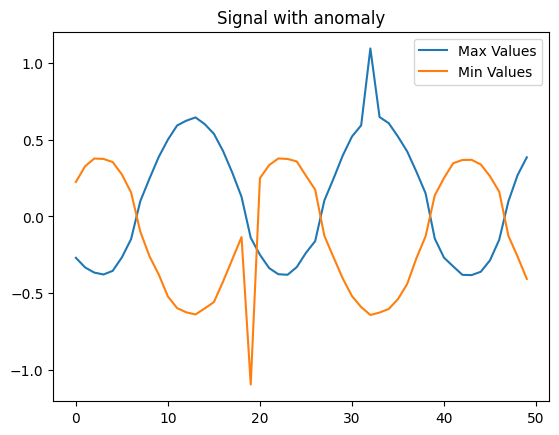

In [16]:
plt.plot(training_samples_max[0],label='Max Values')
plt.plot(training_samples_min[1],label='Min Values')
plt.title('Signal with anomaly')
plt.legend(loc='upper right') 

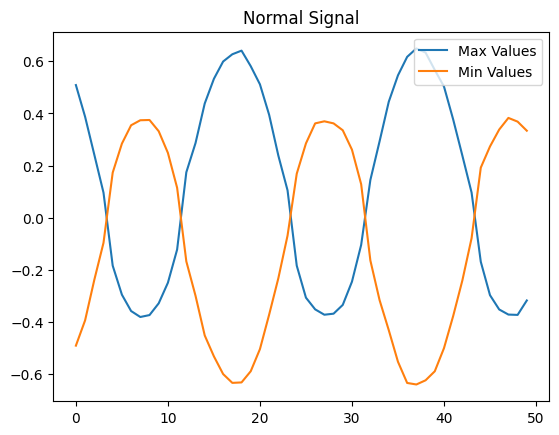

In [17]:
plt.plot(training_samples_normal_max[0],label='Max Values')
plt.plot(training_samples_normal_min[1],label='Min Values')
plt.title('Normal Signal')
plt.legend(loc='upper right') 

### 4.1 Split the training dataset into training and validation sets.
80/20 split is used in this tutorial.

In [18]:
def combine_training_samples(values_max, values_min, window_size=50):
    
    combined_dataset = []

    for sample_min, sample_max in zip(values_min, values_max):

        if len(sample_max) != len(sample_min):
            raise ValueError("Both input lists must have the same number of samples.")
        
        combined_sample = sample_max + sample_min
        combined_dataset.append(combined_sample)
        
    return combined_dataset


In [19]:
training_dataset_anomaly = combine_training_samples(training_samples_max, training_samples_min, window_size=50)
anomaly_sample_n = len(training_dataset_anomaly)          # n. of samples
print(len(training_dataset_anomaly[0]))         # datapoints per sample

training_dataset_normal = combine_training_samples(training_samples_normal_max, training_samples_normal_min, window_size=50)
print(len(training_dataset_normal))            # n. of samples
print(len(training_dataset_normal[0]))         # datapoints per sample

full_training_dataset = training_dataset_anomaly + training_dataset_normal

100
2400
100


In [20]:
'''train_size = int(0.8 * len(full_training_dataset))
val_size = len(full_training_dataset) - train_size

indices = list(range(len(full_training_dataset)))


# Split the indices into training and validation sets
train_indices = indices[:train_size]
val_indices = indices[train_size:]

print(f"Tot n. of frames in the training dataset: {train_size}")
print(f"Tot n. of frames in the validation dataset: {val_size}")'''

'train_size = int(0.8 * len(full_training_dataset))\nval_size = len(full_training_dataset) - train_size\n\nindices = list(range(len(full_training_dataset)))\n\n\n# Split the indices into training and validation sets\ntrain_indices = indices[:train_size]\nval_indices = indices[train_size:]\n\nprint(f"Tot n. of frames in the training dataset: {train_size}")\nprint(f"Tot n. of frames in the validation dataset: {val_size}")'

In [21]:
total_size_full = len(full_training_dataset)
# Find anomaly indices (first 10 from each half)

anomaly_indices = list(range(0, anomaly_sample_n))

# All other indices are normal
normal_indices = list(range(anomaly_sample_n, total_size_full))

total_size = total_size_full - len(anomaly_indices)
train_size = int(0.8 * total_size)
val_size = total_size - train_size


# Shuffle for random sampling
np.random.shuffle(anomaly_indices)
np.random.shuffle(normal_indices)

# Select anomalies
num_train_anomalies = int(0.8*len(anomaly_indices))
num_val_anomalies = len(anomaly_indices) - num_train_anomalies
train_anomaly_indices = anomaly_indices[:num_train_anomalies]
val_anomaly_indices = anomaly_indices[num_train_anomalies:num_train_anomalies + num_val_anomalies]

# Select normals
train_normal_indices = normal_indices[:train_size]
val_normal_indices = normal_indices[train_size:]

print(len(train_normal_indices), len(val_normal_indices))

# Combine and shuffle
train_indices = train_anomaly_indices + train_normal_indices
val_indices = val_anomaly_indices + val_normal_indices

np.random.shuffle(train_indices)
np.random.shuffle(val_indices)


print(f"Anomalies in train: {len([i for i in train_indices if i in train_anomaly_indices])}")
print(f"Anomalies in validation: {len([i for i in val_indices if i in val_anomaly_indices])}")

1920 480
Anomalies in train: 960
Anomalies in validation: 240


### To add - ensure there are anomalies in the validation dataset

In [22]:
# Create train and validation datasets with the generated indices
training_inputs = [full_training_dataset[i] for i in train_indices]
validation_inputs = [full_training_dataset[i] for i in val_indices]

## 5. Define the model and train

In [23]:
# Set up the early stopping - the below checks every 10 epochs 

early_stopping_config = {
    'patience': 10,   # Allow 10 epochs without improvement
    'restore_best_weights': True
}

In [24]:
# model definition for an autoencoder
frame_length = len(training_inputs[0])

# train the model
quant_mod.set_training_data(training_inputs=training_inputs, training_outputs=training_inputs)
model_definition = [(64, 'relu'), (32, 'relu'), (16, 'relu'), (frame_length, 'linear')]

# build the model
#quant_mod.construct_model(model_definition, show_summary=True)
quant_mod.construct_model(model_definition)

In [25]:
history = quant_mod.fit_model(epochs=100, es_config=early_stopping_config, validation_split=0.1)

Value for monitor missing. Using default:val_loss.
Value for restore missing. Using default:False.


Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2982 - val_loss: 0.1330
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1013 - val_loss: 0.0409
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0356 - val_loss: 0.0214
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0221 - val_loss: 0.0170
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0184 - val_loss: 0.0159
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0188 - val_loss: 0.0154
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0180 - val_loss: 0.0151
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - val_loss: 0.0148
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0159 - val_loss: 0.0146
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0170 - val_loss: 0.0144
Epoch 11/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0162 - val_loss: 0.0143
Epoch 12/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0

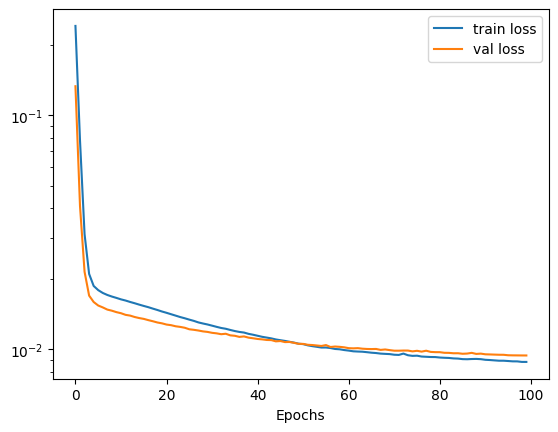

In [26]:
# plot the losses
plt.semilogy(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.xlabel('Epochs')
plt.show()

In [27]:
save_linn(quant_mod, input_channels=1, output_channels=1, file_name='AD_autoencoder.linn')

Skipping layer 0 with type <class 'keras.src.layers.core.input_layer.InputLayer'>
Skipping layer 2 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 4 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 6 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 8 with type <class 'moku.nn._linn.OutputClipLayer'>
Network latency approx. 224 cycles


# 6. Testing the model - reconstruct the training dataset
This is used to see how well the model has learnt to reconstruct the data from the training dataset

**Reconstruction error** in the context of te autoencoders is the difference between the original input signal and the signal the model tries to reconstruct after encoding and decoding it. In our code, this would be the difference between training_inputs and reconstructions variables.

When the autoencoder is trained on normal data (that may contains sporadic anomalies like our training dataset), it learns the typical shape and patterns of the signal. So, when the AutoEncoder sees something unusual or unexpected (an anomaly), it struggles to reconstruct it accurately — resulting in a higher reconstruction error. 

By looking at where this error is large, we can spot potential anomalies that deviate from the learned normal behavior.

In [28]:
reconstructions = []
reconstructions = quant_mod.predict(full_training_dataset)

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step


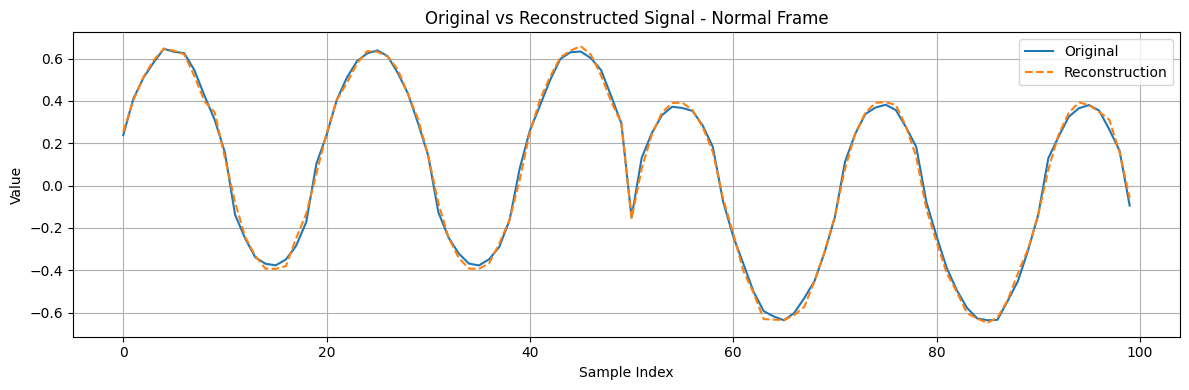

In [29]:
frame_id_normal = 2001

plt.figure(figsize=(12, 4))
plt.plot(full_training_dataset[frame_id_normal], label='Original')
plt.plot(reconstructions[frame_id_normal], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal - Normal Frame')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


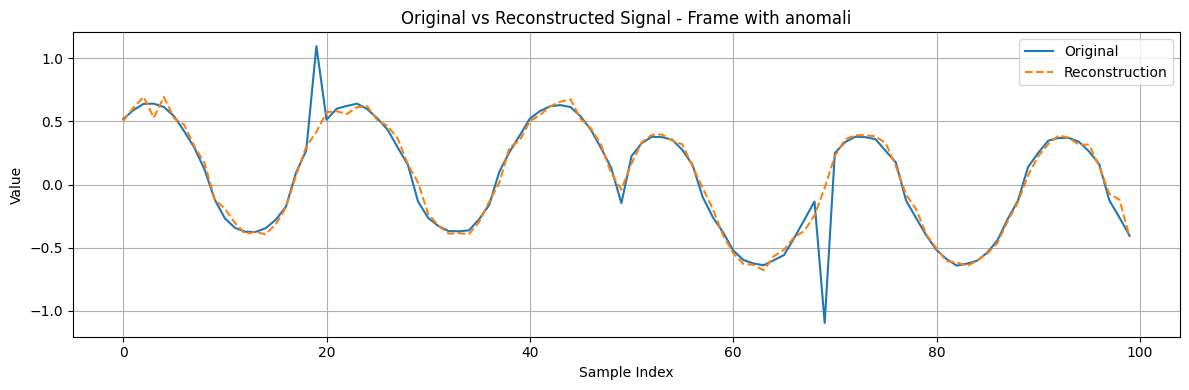

In [43]:
frame_id_anomaly = 1

plt.figure(figsize=(12, 4))
plt.plot(full_training_dataset[frame_id_anomaly], label='Original')
plt.plot(reconstructions[frame_id_anomaly], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal - Frame with anomali')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:

original = np.array(full_training_dataset)
reconstructed = np.array(reconstructions)

# --- Error Calculations ---
# Element-wise absolute error
absolute_error = np.abs(original - reconstructed)

# Element-wise squared error
squared_error = (original - reconstructed) ** 2

# Total error per sample (row-wise)
absolute_error_per_frame = absolute_error.sum(axis=1)
squared_error_per_frame = squared_error.sum(axis=1)


### Absolute error

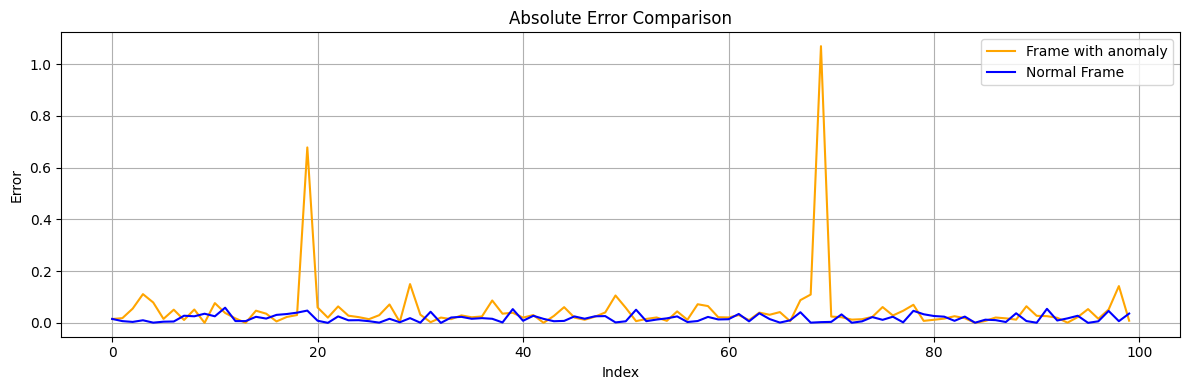

In [45]:
# --- Plotting both frame_ids together ---
plt.figure(figsize=(12, 4))

plt.plot(absolute_error[frame_id_anomaly], label='Frame with anomaly', color='orange')
plt.plot(absolute_error[frame_id_normal], label='Normal Frame', color='blue')

plt.title('Absolute Error Comparison')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
threshold = 0.15

# Find indices where value > threshold

# Frame with Anomaly
indices = [i for i, v in enumerate(absolute_error[frame_id_anomaly]) if v > threshold]

# Print results
print("Frame with anomaly")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [absolute_error[frame_id_anomaly][i] for i in indices])


print("-------------------------------------------------------------------------------")


# Normal with Anomaly
indices = [i for i, v in enumerate(absolute_error[frame_id_normal]) if v > threshold]

# Print results
print("Normal frame")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [absolute_error[frame_id_normal][i] for i in indices])

Frame with anomaly
Indices of values > threshold: [19, 29, 69]
Corresponding values: [np.float64(0.6781308566650788), np.float64(0.1500732179438987), np.float64(1.0693598994484583)]
-------------------------------------------------------------------------------
Normal frame
Indices of values > threshold: []
Corresponding values: []


### Squared error

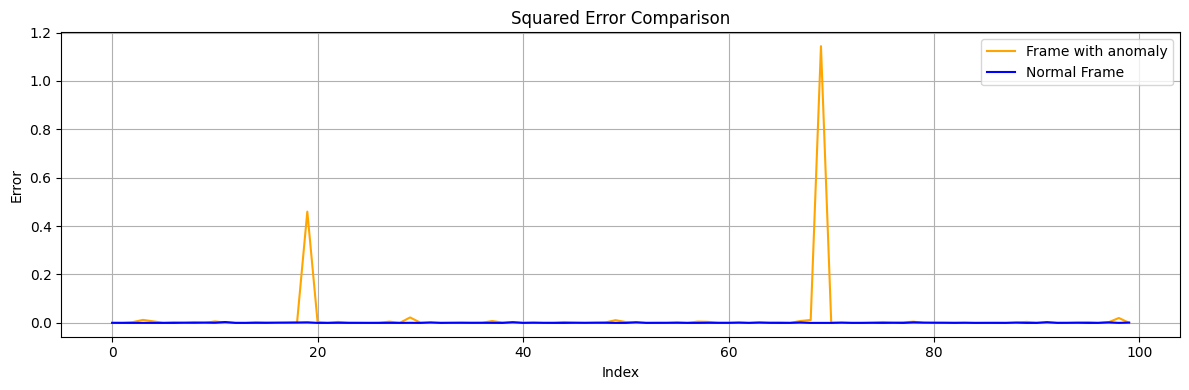

In [47]:
# --- Plotting both frame_ids together ---
plt.figure(figsize=(12, 4))

plt.plot(squared_error[frame_id_anomaly], label='Frame with anomaly', color='orange')
plt.plot(squared_error[frame_id_normal], label='Normal Frame', color='blue')

plt.title('Squared Error Comparison')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
threshold = 0.03

# Find indices where value > threshold

# Frame with Anomaly
indices = [i for i, v in enumerate(squared_error[frame_id_anomaly]) if v > threshold]

# Print results
print("Frame with anomaly")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [squared_error[frame_id_anomaly][i] for i in indices])


print("-------------------------------------------------------------------------------")


# Normal with Anomaly
indices = [i for i, v in enumerate(squared_error[frame_id_normal]) if v > threshold]

# Print results
print("Normal frame")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [squared_error[frame_id_normal][i] for i in indices])

Frame with anomaly
Indices of values > threshold: [19, 69]
Corresponding values: [np.float64(0.4598614587613136), np.float64(1.1435305945484169)]
-------------------------------------------------------------------------------
Normal frame
Indices of values > threshold: []
Corresponding values: []


### Focal loss

In [49]:
def focal_mse_loss(prediction, target, gamma=2.5):
    error = prediction - target
    squared_error = error ** 2
    loss = squared_error ** gamma
    return loss

In [50]:
# --- Focal Loss Calculation ---
focal_loss = focal_mse_loss(reconstructed, original)  # element-wise focal loss

# Total focal loss per sample (row-wise sum)
focal_loss_per_frame = focal_loss.sum(axis=1)

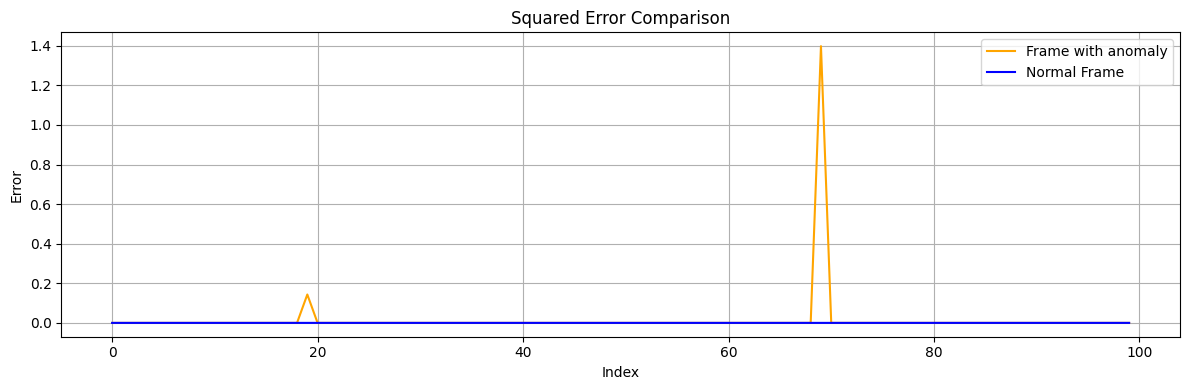

In [51]:
# --- Plotting both frame_ids together ---
plt.figure(figsize=(12, 4))

plt.plot(focal_loss[frame_id_anomaly], label='Frame with anomaly', color='orange')
plt.plot(focal_loss[frame_id_normal], label='Normal Frame', color='blue')

plt.title('Squared Error Comparison')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
threshold = 0.0001

# Find indices where value > threshold

# Frame with Anomaly
indices = [i for i, v in enumerate(focal_loss[frame_id_anomaly]) if v > threshold]

# Print results
print("Frame with anomaly")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [focal_loss[frame_id_anomaly][i] for i in indices])


print("-------------------------------------------------------------------------------")


# Normal with Anomaly
indices = [i for i, v in enumerate(focal_loss[frame_id_normal]) if v > threshold]

# Print results
print("Normal frame")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [focal_loss[frame_id_normal][i] for i in indices])

Frame with anomaly
Indices of values > threshold: [19, 69]
Corresponding values: [np.float64(0.14340606912438988), np.float64(1.3983615408063537)]
-------------------------------------------------------------------------------
Normal frame
Indices of values > threshold: []
Corresponding values: []
